![BridgingAI Logo](../bridgingai_logo.png)

# Deep Learning - Exercise 1: Introduction to PyTorch
---
1. [PyTorch Basics](#basics)
2. [Modules and Optimizers](#training)
3. [Data Loading](#data)
3. [Digit Classification on MNIST](#mnist)
---

In [1]:
# many useful functions live directly in the torch module
import torch
# torch.nn contains network layers, loss functions, etc. as Modules which manage some internal state (eg parameters and buffers)
import torch.nn as nn
# all of them are also available in functional form (no internal state) in torch.nn.functional
import torch.nn.functional as F
# torch.optim contains optimizers such as SGD, Adam, etc.
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

from exercise_utils.core import make_summary_writer
import utils

torch.manual_seed(42)  # set seed for reproducibility

TWO_LAYER_NET_PATH = "TwoLayerNet.pt"

<a id="basics"></a>
## 1. PyTorch Basics

[PyTorch](https://pytorch.org/) is a popular deep learning framework. It provides NumPy-like vectorized operations with support for automatic differentiation and hardware acceleration. From a very simple point of view,  

`PyTorch = NumPy + Automatic differentiation + GPU support.`

Additionally, there is a vast ecosystem of additional packages and libraries based on PyTorch.

We will briefly illustrate the basics in the following code cells. For a more comprehensive reference of PyTorch, you can then check the [documentation](https://pytorch.org/docs/stable/) and also the [tutorials](https://pytorch.org/tutorials).

### Tensors
`torch.Tensor` is PyTorch's fundamental data structure - a generalization of arrays and matrices. Tensors support arbitrary dimensions (from 0D scalars to high-dimensional arrays), different underlying datatypes (such as int8 or fp64), and operations on them can seamlessly utilize different hardware (e.g., CPU or GPU).

The following code cells illustrate the basic operations on tensors. They look very similar to numpy operations, and they obey the same shape [broadcasting rules](https://pytorch.org/docs/stable/notes/broadcasting.html).

In [2]:
# Creating Tensors and basic operations

# make new tensor by copying existing data
a = torch.tensor([1.0, 2.0, 3.0])
b = torch.tensor(np.zeros((3, 3)))
# shapes must match, but pytorch is smart about broadcasting (like numpy)
c = a + b
print(a.shape, b.shape, c.shape)
print(c)
print()

# as_tensor tries to reuse the same memory if possible
d = torch.as_tensor(4)
e = torch.as_tensor([[1.0, 2.0], [3.0, 4.0]])
# indexing is similar to numpy
f = 3 * b[1:, :2] + d * e
print(f.shape)
print(f)
print()

# torch provides many functions for creating tensors
g = torch.randn((3, 3))  # Random numbers from a normal distribution
h = torch.ones_like(g)  # Ones with the same shape as tensor3
print(d * e)
print()

# Matrix Multiplication
matrix1 = torch.randn(300, 500)
matrix2 = torch.randn(500, 800)
matrix_mul = torch.matmul(matrix1, matrix2)
matrix_mul2 = matrix1 @ matrix2  # shorthand for matmul

print(matrix_mul2.shape)

torch.Size([3]) torch.Size([3, 3]) torch.Size([3, 3])
tensor([[1., 2., 3.],
        [1., 2., 3.],
        [1., 2., 3.]], dtype=torch.float64)

torch.Size([2, 2])
tensor([[ 4.,  8.],
        [12., 16.]], dtype=torch.float64)

tensor([[ 4.,  8.],
        [12., 16.]])

torch.Size([300, 800])


Pytorch supports many of NumPy's operations as well. If you want to interface with other libraries that expect NumPy arrays instead of tensors, you can convert a `torch.tensor` to a `numpy.array` by simply calling `.numpy()` on it.

Run the following cell to visualize a 3D gaussian distribution - note how we convert the tensors to arrays as we pass them to matplotlib:

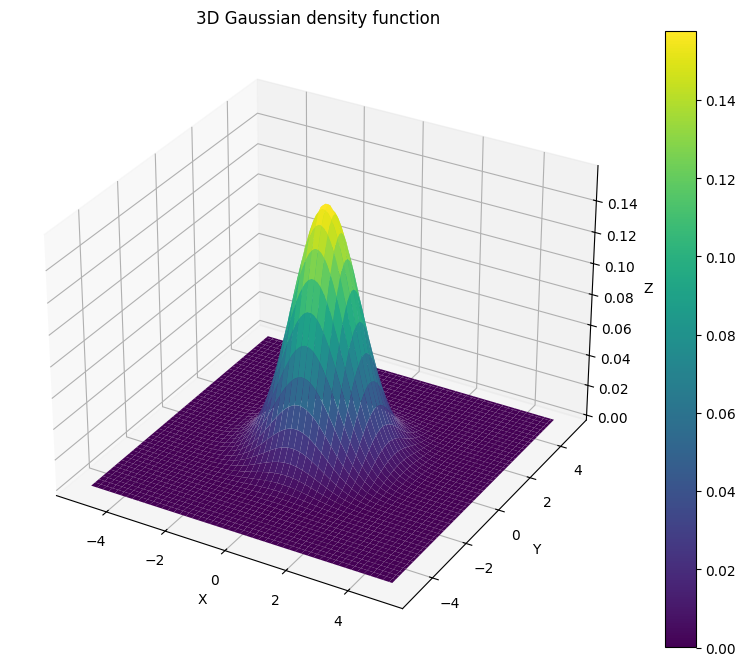

In [3]:
# Create a grid of points
x = torch.linspace(-5, 5, 100)
y = torch.linspace(-5, 5, 100)
X, Y = torch.meshgrid(x, y, indexing="ij")

# Compute the Gaussian function
Z = torch.exp(-(X**2 + Y**2) / 2) / (2 * torch.pi)

# Create a 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d")

# Plot the surface
surf = ax.plot_surface(X.numpy(), Y.numpy(), Z.numpy(), cmap="viridis")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.set_title("3D Gaussian density function")
fig.colorbar(surf)
plt.show()

### Automatic differentiation
PyTorch's autograd engine ([torch.autoGrad](https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html)) allows us to compute gradients of the parameters with respect to the loss function. When we perform operations on tensors, PyTorch keeps track of the operations by creating a computation graph under the hood. This computation graph is then used to compute the gradients using Backpropagation.

Run the following code cell for a very simple example of autograd in action. What happens when you set `requires_grad=False` for one of the tensors, and what if you multiply one of them with zeros?

In [4]:
# Set requires_grad=True to track computations
a = torch.tensor([1.0, 2.0, 3.0], requires_grad=True)
b = torch.tensor([4.0, 5.0, 6.0], requires_grad=True)
c = (a + b).sum()

# Call backward on a scalar to compute gradients
c.backward()

print("Output:", c)
print("Grad a:", a.grad)
print("Grad b:", b.grad)

Output: tensor(21., grad_fn=<SumBackward0>)
Grad a: tensor([1., 1., 1.])
Grad b: tensor([1., 1., 1.])


Sometimes, we want to avoid the overhead of tracking computations, or we do not want to compute gradients for some operations (for example during evaluation, or while updating parameters manually). In that case, we can disable gradient tracking using `torch.no_grad()`, which works both as a decorator and a context manager.

In [5]:
a = torch.tensor([1.0, 2.0, 3.0], requires_grad=True)
print("With gradient tracking:", 2 * a)

with torch.no_grad():
    print("Without gradient tracking:", 2 * a)

With gradient tracking: tensor([2., 4., 6.], grad_fn=<MulBackward0>)
Without gradient tracking: tensor([2., 4., 6.])


Play around with the following code cell to see how we can implement logistic regression with PyTorch's AutoGrad engine.

loss: 0.00227: 100%|██████████| 5000/5000 [00:01<00:00, 3026.13it/s]


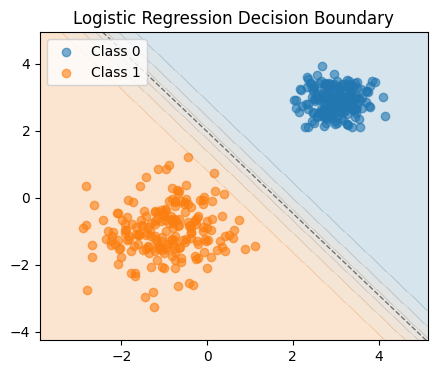

In [6]:
# Logistic Regression
def run_logistic_regression(data, labels, num_iterations=5000, learning_rate=0.1):
    weights = torch.randn(data.shape[1], requires_grad=True)

    pbar = tqdm(range(num_iterations))
    for i in pbar:
        # compute the cross entropy loss
        logits = data @ weights
        pred = torch.sigmoid(logits)
        loss = F.binary_cross_entropy(pred, labels)

        # compute gradients
        loss.backward()

        # manual implementation of gradient descent
        # later, this will be handled by an optimizer from torch.optim
        with torch.no_grad():
            weights += -learning_rate * weights.grad
            # reset gradients (otherwise they accumulate)
            weights.grad = None

        pbar.set_description(f"loss: {loss.item():.5f}")

    # return a copy without gradient tracking
    return weights.detach()


# datasets available: "binary_blob", "two_moons", "xor", "concentric_circles"
data, labels = utils.get_dataset("binary_blob")


def polynomial_features(data, degree):
    x1, x2 = data[:, 1], data[:, 2]
    features = [data[:, 0]]  # Keep bias column

    for i in range(1, degree + 1):
        for j in range(i + 1):
            features.append((x1 ** (i - j)) * (x2**j))

    return torch.stack(features, dim=1)


# increase the degree to get a non-linear decision boundary
feature_transform = lambda x: polynomial_features(x, degree=1)

# Training the model
weights = run_logistic_regression(feature_transform(data), labels)

# Plot the decision boundary
utils.plot_logistic_regression(data, labels, weights, feature_transform)

### Hardware acceleration
PyTorch operations seamlessly run on various hardware:
- CPU: Default execution device
- CUDA: NVIDIA GPU acceleration (also supports AMD GPUs to some degree)
- MPS: Apple Silicon optimization
- TPU: Google's Tensor Processing Units

In PyTorch, these accelerators are called "devices". For example, you can run the operations from above on the GPU, by simply moving the tensors to the correct device. This way, almost all hardware-specific code is abstracted away.

You can call the `to()` method on many PyTorch objects to move the associated data to another device, for example `t.to('cuda')` to move a tensor `t` to the default GPU.
If you create new tensors, it is often more performant to create them directly on the device - simply specify the the `device` attribute in the constructor.

Hardware acceleration and parallelization enables tremendous speedups - you will see that by running the next cell.

In [7]:
# this timer takes care of proper device synchronization and warm-up
from torch.utils.benchmark import Timer

N = 1000


def benchmark_matmul(device, nthreads):
    a = torch.randn(N, N, device=device)
    b = torch.randn(N, N, device=device)

    def func():
        return a @ b

    timer = Timer(
        stmt="func()",
        globals={"func": func},
        num_threads=nthreads,
        label=f"matmul ({device})",
    )
    time = timer.blocked_autorange().mean

    print(f"{device} ({nthreads} threads): {time*1000:.3f}ms")

    # print(Timer("func()", globals={"func": func}, num_threads=nthreads).blocked_autorange().mean)


nthreads = torch.get_num_threads()
# baseline: cpu, using a single core
benchmark_matmul("cpu", nthreads=1)
# torch uses all available cores by default
benchmark_matmul("cpu", nthreads=nthreads)

if torch.cuda.is_available():
    # dedicated GPU (NVIDIA or AMD)
    benchmark_matmul("cuda", nthreads=nthreads)

if torch.backends.mps.is_available():
    # Metal Performance Shaders (MPS) on Apple Silicon
    benchmark_matmul("mps", nthreads=nthreads)

cpu (1 threads): 13.634ms
cpu (8 threads): 1.844ms
cuda (8 threads): 0.152ms


<a id="training"></a>
## 2. Modules and Optimizers

In the examples above, we implemented gradient descent from scratch and also handled all the parameters ourselves. Fortunately, PyTorch provides an easier way to do all that, using _modules_ and _optimizers_.

`torch.nn.Module` is the base class of most neural network layers in PyTorch. To implement a custom module, you extend this class and implement the `forward` function. The Module instance wraps all relevant state, such as learnable or non-learnable parameters, configuration, or meta information. Learnable parameters are usually tensors wrapped in `torch.nn.Parameter`, which automatically register the data to the enclosing module to make data handling easier.

`torch.nn` contains many often-used building blocks of neural networks: linear layers, convolutions, recurrent layers, activation functions, and many more. `torch.nn.functional` provides a functional interface to these functions.

`torch.optim` implements various optimizers, learning rate schedulers, and facilities for weight averaging.

We implemented a simple custom module in the cell below.

In [8]:
class MyModule(nn.Module):
    def __init__(self, in_features, out_features):
        # make sure to call the parent constructor
        super().__init__()

        # nn.Parameter is a special kind of Tensor used for learnable parameters
        # these will be automatically added to the list of module parameters
        self.W = nn.Parameter(torch.randn(in_features, out_features))
        self.b = nn.Parameter(torch.zeros(out_features))

        self.activation = nn.Sigmoid()

    def forward(self, x):
        return self.activation(x @ self.W + self.b).sum()


mymodule = MyModule(3, 4)
for n, p in mymodule.named_parameters():
    print(n, p.shape)

# to apply a module, simply call it like a function
data = torch.randn(2, 3)
output = mymodule(data)
print(output)

W torch.Size([3, 4])
b torch.Size([4])
tensor(2.7537, grad_fn=<SumBackward0>)


Luckily, torch already contains a large variety of common operations. To build an MLP, for example, we can use the `torch.nn.Sequential` class, as in the following.

In [9]:
mlp = nn.Sequential(
    nn.Linear(3, 4),
    nn.ReLU(),
    nn.Linear(4, 2),
)

print(mlp)

Sequential(
  (0): Linear(in_features=3, out_features=4, bias=True)
  (1): ReLU()
  (2): Linear(in_features=4, out_features=2, bias=True)
)


So now we can implement networks and automatically compute gradients using PyTorch. To train networks, we now need to use the gradients to update the parameters, for example, using stochastic gradient descent. PyTorch has us covered, with `torch.optim.SGD` (and several other, more complex optimizers).

To use an optimizer, we pass a the network parameters to the constructor, together with the necessary hyperparameters (e.g., the learning rate for SGD). In each iteration, we call `.step()` and `.zero_grad()` to update the parameters and clear the gradients. See how we can easily learn to classify the toy data from above.

Play around with this example - what do you observe when you change the network architecture, e.g., a larger or smaller hidden dimension, a different activation function, or more layers? What happens when you omit the call to `.zero_grad()`?

100%|██████████| 2000/2000 [00:00<00:00, 4243.78it/s]


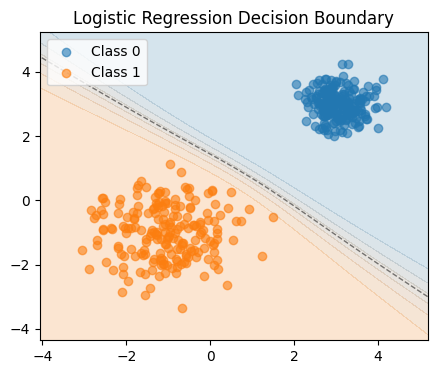

In [10]:
num_iterations = 2000
hidden_dim = 128
# we specify bias=False because the data already has a bias column
mlp = nn.Sequential(
    nn.Linear(3, hidden_dim, bias=False), nn.Tanh(), nn.Linear(hidden_dim, 1)
)
optimizer = optim.SGD(mlp.parameters(), lr=0.1)

# same datasets as before - "binary_blob", "two_moons", "xor", "concentric_circles"
data, labels = utils.get_dataset("binary_blob")

for _ in tqdm(range(num_iterations)):
    # squeeze removes unit dimensions (in this case, the last dimension)
    pred = mlp(data).squeeze()
    # combines sigmoid and binary cross entropy loss; more numerically stable
    loss = F.binary_cross_entropy_with_logits(pred, labels)
    loss.backward()

    # update the weights
    optimizer.step()
    # reset the gradients
    optimizer.zero_grad()

# slice the sequential model to simulate a linear model with learned features
weights = mlp[-1].weight.detach().T
feature_transform = lambda x: mlp[:-1](x)

# Plot the decision boundary
utils.plot_logistic_regression(data, labels, weights, feature_transform)

### Saving & Loading Checkpoints

When training models, it's crucial to save checkpoints periodically. This allows you to resume training from a specific point if it gets interrupted, and to use the trained model for inference later. PyTorch provides an easy way to save and load model internal state via the `.state_dict()` method, which is supported by modules and optimizers.

To save a checkpoint, you typically want to include:
1. The model's state dictionary
2. The optimizer's state dictionary
3. Any other relevant information (e.g., epoch number, best validation loss)

For example, we might save a checkpoint like this:

```python
def save_checkpoint(model, optimizer, epoch, best_val_loss, filepath):
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'best_val_loss': best_val_loss,
    }, filepath)

# Usage example
save_checkpoint(model, optimizer, epoch, best_val_loss, 'checkpoint.pth')
```

And later load a checkpoint to resume training or use the model for inference like this:

```python
def load_checkpoint(filepath, model, optimizer=None):
    checkpoint = torch.load(filepath)
    model.load_state_dict(checkpoint['model_state_dict'])
    if optimizer:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    best_val_loss = checkpoint['best_val_loss']
    return model, optimizer, epoch, best_val_loss

# Usage example
model, optimizer, start_epoch, best_val_loss = load_checkpoint('checkpoint.pth', model, optimizer)
```

Note that you will encounter an error if the names and shapes of parameters in the checkpoint and in the model definition do not match.

We have saved a checkpoint of a two-layer MLP trained on MNIST in this directory. You can load it by running the following cell.

In [11]:
two_layer_mlp = nn.Sequential(
    nn.Linear(784, 128),
    nn.ReLU(),
    nn.Linear(128, 10),
)

checkpoint = torch.load(TWO_LAYER_NET_PATH, weights_only=True)
two_layer_mlp.load_state_dict(checkpoint)

<All keys matched successfully>

<a id="data"></a>
## 3. Data Loading

When training on large datasets, it is not feasible to load the entire dataset into memory at once. Instead, we need to divide the dataset into smaller batches and load them one by one. PyTorch provides the `DataLoader` class for this task: It provides functionality for multi-process dataloading, shuffling, and batching. We only need to implement a `Dataset`, which we can then pass to the dataloader.

In many cases, a dataset just maps some index (e.g., an integer) to a sample. You can find good examples for how to create custom datasets in the [documentation](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html).

The following cell demonstrates how to use the `DataLoader` class to load the [MNIST dataset](https://en.wikipedia.org/wiki/MNIST_database). Run the cell to see a few samples from the dataset.

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 10.6MB/s]


Extracting ../datasets/MNIST/raw/train-images-idx3-ubyte.gz to ../datasets/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 290kB/s]


Extracting ../datasets/MNIST/raw/train-labels-idx1-ubyte.gz to ../datasets/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 2.76MB/s]


Extracting ../datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to ../datasets/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 15.3MB/s]

Extracting ../datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../datasets/MNIST/raw

60000 training samples 10000 test samples


Inside a batch: 
  Image batch shape: torch.Size([64, 1, 28, 28])
  Label batch shape: torch.Size([64])


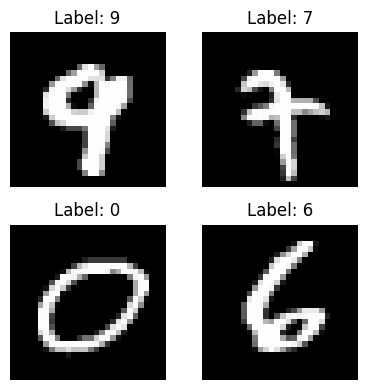

In [12]:
from torchvision import datasets, transforms

# Define the transformation to apply to the data
transform = transforms.Compose(
    [
        transforms.ToTensor(),  # Convert the image to a tensor
        transforms.Normalize((0.5,), (0.5,)),  # Normalize the image data
    ]
)

# Load the MNIST training dataset
train_dataset = datasets.MNIST(
    root="../datasets", train=True, download=True, transform=transform
)

# Load the MNIST test dataset
test_dataset = datasets.MNIST(
    root="../datasets", train=False, download=True, transform=transform
)

print(len(train_dataset), "training samples", len(test_dataset), "test samples")

# Using multiple workers usually speeds up the data loading (up to a point)
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=64, shuffle=True, num_workers=4
)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=True)

# To use the data loader, we can just iterate over it...
# Let's see what we get from this data loader
for images, labels in train_loader:
    print(f"Inside a batch: ")
    print(f"  Image batch shape: {images.shape}")
    print(f"  Label batch shape: {labels.shape}")
    utils.make_grid(images[:4], labels=labels[:4])
    break

<a id="mnist"></a>
## 4. Digit Classification on MNIST

Now it's your turn! You will implement a neural network for MNIST classification using PyTorch. The neural network will be a multi-layer perceptron (MLP) with ReLU activations, defined as:
```python
# INPUT -> [Linear() -> ReLU()] x num_hidden_layers -> Linear() -> OUTPUT
```
The loss function should be the softmax cross-entropy loss. 

**TODOs:**
1. Complete `__init__`, `forward` and `optimizer` methods of the `MLP` class.
2. Complete the training loop in the `train` function to perform the forward pass, backward pass and update steps.
3. Launch tensorboard by running the command `tensorboard --logdir=runs` in the terminal to inspect the training process.

<details>
<summary>View the training logs with tensorboard</summary>
TensorBoard is a convenient tool for visualizing training progress and performance metrics. We will often use tensorboard to log the training process in the following exercises.

Follow these steps to get started with TensorBoard:
1. Open a terminal.
2. Navigate to the directory where your log files are stored (here, this will be the same directory as this notebook).
3. Run the following command to launch TensorBoard:
```bash
tensorboard --logdir=runs
```
4. Once TensorBoard is running, it will provide a URL (the default is http://localhost:6006/) that you can open in your web browser to view the dashboard. If you don't see any data, try refreshing the page and make sure that the log directory is correct.

To use tensorboard in your own experiments, have a look at [How to use TensorBoard with PyTorch](https://pytorch.org/tutorials/recipes/recipes/tensorboard_with_pytorch.html).
</details>

**Hints:**
- To construct a neural network, you can use `nn.Sequential` to stack layers sequentially. An alternative way is to use the `nn.ModuleList` class to store the layers in a list, then iterate through the list to perform the forward pass. Please read the documentations to learn how to use them: [Sequential](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html), [ModuleList](https://pytorch.org/docs/stable/generated/torch.nn.ModuleList.html)
- As a sanity check, you can print the test loss for an untrained model. It should be around `2.3` (since the model is initialized randomly, the output is close to uniform distribution, and the cross-entropy loss for uniform distribution is `-log(1/n_classes) = -log(1/10) = 2.3`). If the initial loss is not around `2.3`, there might be a bug in your code.
- You can use the cross-entropy loss implemented by PyTorch, please refer this [documentation](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)
- Documentation for the `SGD` optimizer can be found [here](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html)

In [13]:
class MLP(nn.Module):
    def __init__(self, config):
        super().__init__()
        input_dim = config[
            "input_dim"
        ]  # The number of input features, which will be 28*28=784 for MNIST
        hidden_dim = config[
            "hidden_dim"
        ]  # The number of hidden units in each hidden layer
        num_hidden_layers = config["num_hidden_layers"]  # The number of hidden layers
        output_dim = config["output_dim"]  # The number of output units

        ### BEGIN SOLUTION
        layers = [nn.Linear(input_dim, hidden_dim), nn.ReLU()]
        for _ in range(num_hidden_layers - 1):
            layers.extend([nn.Linear(hidden_dim, hidden_dim), nn.ReLU()])
        layers.append(nn.Linear(hidden_dim, output_dim))
        self.network = nn.Sequential(*layers)
        ### END SOLUTION

    def forward(self, x):
        """
        Inputs:
        - x: A tensor of shape (batch_size, input_dim)

        Returns:
        - logits: Model output, a tensor of shape (batch_size, output_dim)
        """
        ### BEGIN SOLUTION
        logits = self.network(x)
        ### END SOLUTION
        return logits


def compute_accuracy(model, data_loader):
    correct = 0
    total = 0
    loss = 0
    criterion = nn.CrossEntropyLoss()
    with torch.no_grad():
        for img, label in data_loader:
            img = img.view(-1, 28 * 28)
            logits = model(img)
            loss += criterion(logits, label).item()
            predicted = logits.argmax(dim=-1)
            total += label.size(0)
            correct += (predicted == label).sum().item()
    return correct / total, loss / len(data_loader)


def train(model, train_loader, test_loader, logger, config):
    optimizer = optim.SGD(model.parameters(), lr=config["lr"])
    criterion = nn.CrossEntropyLoss()
    pbar = tqdm(range(config["epochs"]))
    for epoch in pbar:
        train_losses = []
        train_correct = 0
        train_total = 0

        for img, label in train_loader:
            # "img" is the input image data having shape (batch_size, 1, 28, 28)
            # "label" is the ground truth label having shape (batch_size)
            img = img.view(
                -1, config["input_dim"]
            )  # Flatten the input data for our MLP

            ### BEGIN SOLUTION
            logits = model(img).squeeze()
            loss = criterion(logits, label)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            ### END SOLUTION

            train_losses.append(loss.item())
            predicted = logits.argmax(dim=-1)
            train_total += label.size(0)
            train_correct += (predicted == label).sum().item()

        # run validation after each epoch
        train_loss = sum(train_losses) / len(train_losses)
        train_accuracy = train_correct / train_total
        test_accuracy, test_loss = compute_accuracy(model, test_loader)
        pbar.set_description(f"Validation accuracy: {test_accuracy:.4f}")

        # log train/test accuracy and train/test loss
        logger.add_scalars(
            "Accuracy", {"train": train_accuracy, "test": test_accuracy}, epoch
        )
        logger.add_scalars("Loss", {"train": train_loss, "test": test_loss}, epoch)

        # Sample images from test set and compute predictions
        sample_size = 16  # 4x4 grid
        sample_images, sample_labels = next(iter(test_loader))
        sample_images = sample_images[:sample_size]
        sample_labels = sample_labels[:sample_size]
        with torch.no_grad():
            sample_logits = model(sample_images.view(-1, config["input_dim"]))
            _, sample_predictions = torch.max(sample_logits, 1)

        # Log some sample predictions
        fig_pred = utils.make_grid(sample_images, sample_predictions, sample_labels)
        logger.add_figure("Sample_Predictions", fig_pred, epoch)

        logger.flush()

    return train_accuracy, test_accuracy, fig_pred


logger = make_summary_writer("MNIST", "MLP")
config = {
    "input_dim": 28 * 28,
    "hidden_dim": 64,
    "num_hidden_layers": 1,
    "output_dim": 10,
    "lr": 3e-2,
    "epochs": 10,
}

model = MLP(config)
test_accuracy, test_loss = compute_accuracy(model, test_loader)
print("Untrained test loss: ", test_loss)
print("Untrained test accuracy: ", test_accuracy)

Untrained test loss:  2.3120022594549092
Untrained test accuracy:  0.0983


If implemented correctly, the default config should yield a test accuracy of around 0.95 after training, which should finish in about a minute.

Validation accuracy: 0.9649: 100%|██████████| 10/10 [00:22<00:00,  2.22s/it]


Finished Training
Final train accuracy:  0.9681166666666666
Final test accuracy:  0.9649


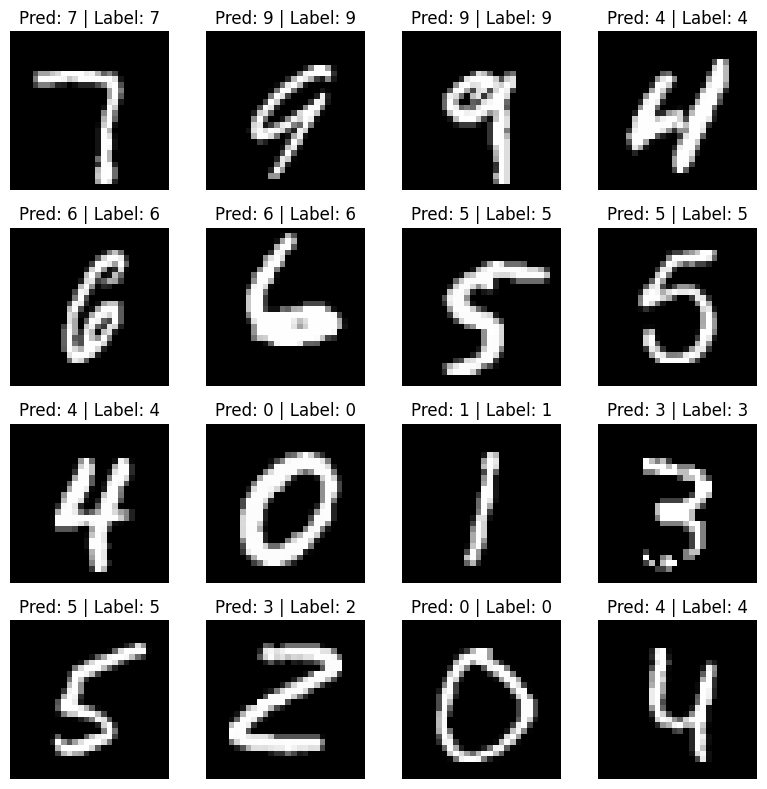

In [14]:
train_accuracy, test_accuracy, fig_pred = train(
    model, train_loader, test_loader, logger, config
)

print("Finished Training")
print("Final train accuracy: ", train_accuracy)
print("Final test accuracy: ", test_accuracy)
fig_pred